In [9]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/ProjectLab

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/ProjectLab


[Int64Index([35, 172, 232, 410, 681, 972, 1027, 1129, 1251], dtype='int64'), Int64Index([359, 362, 584, 747, 1033, 1212, 1231, 1282, 1316], dtype='int64'), Int64Index([121, 157, 295, 492, 940, 1041], dtype='int64'), Int64Index([0, 31, 133, 236, 296, 349, 529, 791, 1296], dtype='int64'), Int64Index([126, 134, 293, 375, 487, 604, 648, 875, 1163], dtype='int64'), Int64Index([37, 219, 388, 714, 821, 989, 1137], dtype='int64'), Int64Index([192, 452, 508, 579, 693, 816, 857, 1002], dtype='int64'), Int64Index([10, 40, 274, 340, 476, 548, 631, 1305], dtype='int64'), Int64Index([28, 248, 428, 593, 680, 802, 990, 1295, 1302], dtype='int64'), Int64Index([15, 326, 468, 469, 636, 897, 1016, 1023, 1048], dtype='int64'), Int64Index([105, 106, 149, 261, 270, 1026, 1170, 1299, 1315], dtype='int64'), Int64Index([76, 117, 249, 282, 291, 434, 465, 784, 952], dtype='int64'), Int64Index([104, 504, 535, 585, 827, 885, 954, 993, 1075, 1081, 1273], dtype='int64'), Int64Index([182, 250, 276, 364, 507, 586, 926,

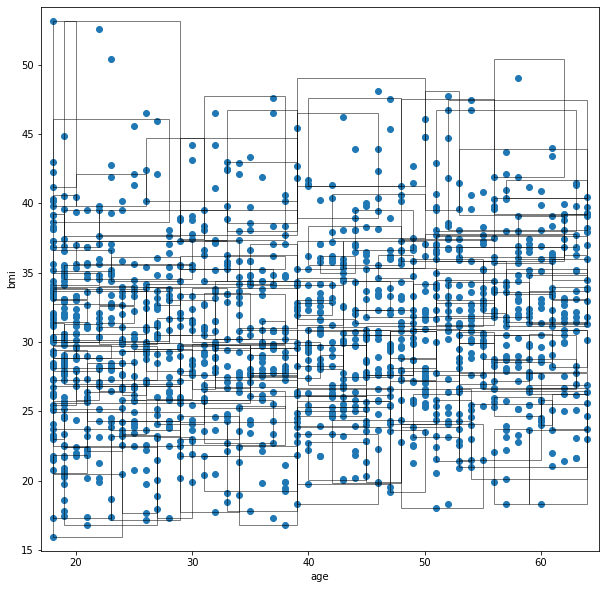

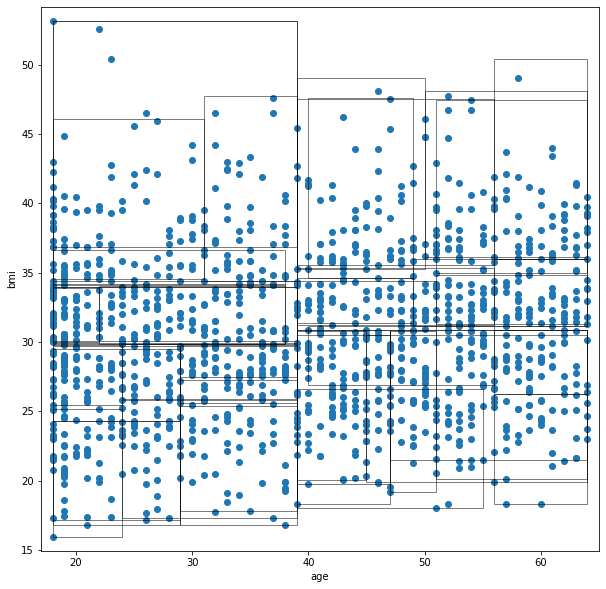

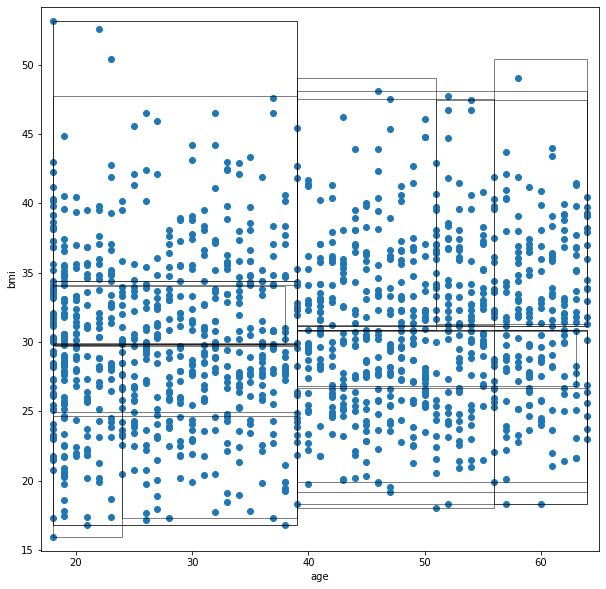

Finished 1 partitions...
Finished 101 partitions...
Finished 1 partitions...
Finished 1 partitions...
           age        bmi  children                 Disease
0    19.666667  18.812778         0                     FLU
1    19.666667  18.812778         0  Bronchial Inflammation
2    18.666667  21.337778         0                     FLU
3    18.666667  21.337778         0               Hepatitis
4    18.666667  21.337778         0  Bronchial Inflammation
..         ...        ...       ...                     ...
491  61.666667  32.369167         2                   Tumor
492  61.666667  32.369167         2              Bronchitus
493  60.571429  32.701429         3               Hepatitis
494  60.571429  32.701429         3                   Tumor
495  60.571429  32.701429         3              Bronchitus

[496 rows x 4 columns]
           age        bmi  children                 Disease
0    19.540541  21.968649         0                     FLU
1    19.540541  21.968649         

In [11]:
import pandas as pd
import matplotlib as plt
import matplotlib.pylab as pl
import matplotlib.patches as patches
df = pd.read_csv('PatientDiseaseData.csv')
df['sex']= df['sex'].map({'male':0,'female':1})
df['smoker']= df['smoker'].map({'yes':1,'no':0})
df['Disease'] = df['Disease'].map({'FLU':1,'Cancer' : 2, 'Hepatitis' : 3, 'Tumor' :4, 'Bronchial Inflammation':5,'Heart Disease':6,'Stomach Inflammation':7,'Bronchitus':8,'AIDS':9})
df['region'] = df['region'].map({'northwest':1,'northeast':2,'southeast':3,'southwest':4})
categorical = set((
    'sex',
    'smoker',
    'region',
    'Disease'
))
for name in categorical:
    df[name] = df[name].astype('category')
def get_spans(df, partition, scale=None):
    spans = {}
    for column in df.columns:
        if column in categorical:
            span = len(df[column][partition].unique())
        else:
            span = df[column][partition].max()-df[column][partition].min()
        if scale is not None:
            span = span/scale[column]
        spans[column] = span
    return spans
full_spans = get_spans(df, df.index)
def split(df, partition, column): 
    dfp = df[column][partition]
    if column in categorical:
        values = dfp.unique()
        lv = set(values[:len(values)//2])
        rv = set(values[len(values)//2:])
        return dfp.index[dfp.isin(lv)], dfp.index[dfp.isin(rv)]
    else:        
        median = dfp.median()
        dfl = dfp.index[dfp < median]
        dfr = dfp.index[dfp >= median]
        return (dfl, dfr)
def is_k_anonymous(df, partition, sensitive_column, k=5):
    if len(partition) < k:
        return False
    return True

def partition_dataset(df, feature_columns, sensitive_column, scale, is_valid,k):
    finished_partitions = []
    partitions = [df.index]
    while partitions:
        partition = partitions.pop(0)
        spans = get_spans(df[feature_columns], partition, scale)
        for column, span in sorted(spans.items(), key=lambda x:-x[1]):
            lp, rp = split(df, partition, column)
            if not is_valid(df, lp, sensitive_column,k) or not is_valid(df, rp, sensitive_column,k):
                continue
            partitions.extend((lp, rp))
            break
        else:
            finished_partitions.append(partition)
    return finished_partitions
feature_columns = ['age', 'bmi', 'children']
sensitive_column = 'Disease'
finished_partitions1 = partition_dataset(df, feature_columns, sensitive_column, full_spans, is_k_anonymous,5)
finished_partitions2 = partition_dataset(df, feature_columns, sensitive_column, full_spans, is_k_anonymous,20)
finished_partitions3 = partition_dataset(df, feature_columns, sensitive_column, full_spans, is_k_anonymous,45)

print(finished_partitions1)
print(finished_partitions2)
print(finished_partitions3)
print(len(finished_partitions1))
print(len(finished_partitions2))
print(len(finished_partitions3))

def build_indexes(df):
    indexes = {}
    for column in categorical:
        values = sorted(df[column].unique())
        indexes[column] = { x : y for x, y in zip(values, range(len(values)))}
    return indexes

def get_coords(df, column, partition, indexes, offset=0.1):
    if column in categorical:
        sv = df[column][partition].sort_values()
        l, r = indexes[column][sv[sv.index[0]]], indexes[column][sv[sv.index[-1]]]+1.0
    else:
        sv = df[column][partition].sort_values()
        next_value = sv[sv.index[-1]]
        larger_values = df[df[column] > next_value][column]
        if len(larger_values) > 0:
            next_value = larger_values.min()
        l = sv[sv.index[0]]
        r = next_value
    l -= offset
    r += offset
    return l, r

def get_partition_rects(df, partitions, column_x, column_y, indexes, offsets=[0.1, 0.1]):
    rects = []
    for partition in partitions:
        xl, xr = get_coords(df, column_x, partition, indexes, offset=offsets[0])
        yl, yr = get_coords(df, column_y, partition, indexes, offset=offsets[1])
        rects.append(((xl, yl),(xr, yr)))
    return rects

def get_bounds(df, column, indexes, offset=1.0):
    if column in categorical:
        return 0-offset, len(indexes[column])+offset
    return df[column].min()-offset, df[column].max()+offset
def plot_rects(df, ax, rects, column_x, column_y, edgecolor='black', facecolor='none'):
    for (xl, yl),(xr, yr) in rects:
        ax.add_patch(patches.Rectangle((xl,yl),xr-xl,yr-yl,linewidth=1,edgecolor=edgecolor,facecolor=facecolor, alpha=0.5))
    ax.set_xlim(*get_bounds(df, column_x, indexes))
    ax.set_ylim(*get_bounds(df, column_y, indexes))
    ax.set_xlabel(column_x)
    ax.set_ylabel(column_y)
indexes = build_indexes(df)
column_x, column_y = feature_columns[:2]
rects1 = get_partition_rects(df, finished_partitions1, column_x, column_y, indexes, offsets=[0.0, 0.0])
rects2 = get_partition_rects(df, finished_partitions2, column_x, column_y, indexes, offsets=[0.0, 0.0])
rects3 = get_partition_rects(df, finished_partitions3, column_x, column_y, indexes, offsets=[0.0, 0.0])

print(rects1)
print(rects2)
print(rects3)

pl.figure(figsize=(10,10))
ax = pl.subplot(111)
plot_rects(df, ax, rects1, column_x, column_y, facecolor='none')
pl.scatter(df[column_x], df[column_y])
pl.show()

pl.figure(figsize=(10,10))
ax = pl.subplot(111)
plot_rects(df, ax, rects2, column_x, column_y, facecolor='none')
pl.scatter(df[column_x], df[column_y])
pl.show()

pl.figure(figsize=(10,10))
ax = pl.subplot(111)
plot_rects(df, ax, rects3, column_x, column_y, facecolor='none')
pl.scatter(df[column_x], df[column_y])
pl.show()


def agg_categorical_column(series):
    return [','.join(set(series))]

def agg_numerical_column(series):
    return [series.mean()]

def build_anonymized_dataset(df, partitions, feature_columns, sensitive_column, max_partitions=None):
    aggregations = {}
    for column in feature_columns:
        if column in categorical:
            aggregations[column] = agg_categorical_column
        else:
            aggregations[column] = agg_numerical_column

    rows = []
    for i, partition in enumerate(partitions):
        if i % 100 == 1:
            print("Finished {} partitions...".format(i))
        if max_partitions is not None and i > max_partitions:
            break

        grouped_columns = df.loc[partition].agg(aggregations, squeeze=False)
       
        sensitive_counts = df.loc[partition].groupby(sensitive_column).agg({sensitive_column : 'count'})
        values = grouped_columns.iloc[0].to_dict()   #ERROR HERE
        for sensitive_value, count in sensitive_counts[sensitive_column].items():
            if count == 0:
                continue
            values.update({
                sensitive_column : sensitive_value

            })
            rows.append(values.copy())
    return pd.DataFrame(rows)
dfn1 = build_anonymized_dataset(df, finished_partitions1, feature_columns, sensitive_column)
dfn2 = build_anonymized_dataset(df, finished_partitions2, feature_columns, sensitive_column)
dfn3 = build_anonymized_dataset(df, finished_partitions3, feature_columns, sensitive_column)
dfn1["children"] = dfn1["children"].astype(int)
dfn1[sensitive_column] = dfn1[sensitive_column].astype(int)
dfn1[sensitive_column] = dfn1[sensitive_column].map({1:'FLU',2: 'Cancer', 3:'Hepatitis',4: 'Tumor',5: 'Bronchial Inflammation',6:'Heart Disease',7:'Stomach Inflammation',8:'Bronchitus',9:'AIDS'})
dfn2["children"] = dfn2["children"].astype(int)
dfn2[sensitive_column] = dfn2[sensitive_column].astype(int)
dfn2[sensitive_column] = dfn2[sensitive_column].map({1:'FLU',2: 'Cancer', 3:'Hepatitis',4: 'Tumor',5: 'Bronchial Inflammation',6:'Heart Disease',7:'Stomach Inflammation',8:'Bronchitus',9:'AIDS'})
dfn3["children"] = dfn3["children"].astype(int)
dfn3[sensitive_column] = dfn3[sensitive_column].astype(int)
dfn3[sensitive_column] = dfn3[sensitive_column].map({1:'FLU',2: 'Cancer', 3:'Hepatitis',4: 'Tumor',5: 'Bronchial Inflammation',6:'Heart Disease',7:'Stomach Inflammation',8:'Bronchitus',9:'AIDS'})
print(dfn1)
print(dfn2)
print(dfn3)


